In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

RESULTADO_DIR = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado")
DATA_FILE = RESULTADO_DIR / "PASO_11_dataset_final" / "dataset_Xy_3dates_yield2025.csv"

df = pd.read_csv(DATA_FILE)
print("df:", df.shape)
print(df.columns.tolist())
df.head()


df: (202, 25)
['plot_id', 'obsUnitId', 'CHLGR_mean_20251002', 'CHLGR_mean_20251103', 'CHLGR_mean_20251210', 'MARI_mean_20251002', 'MARI_mean_20251103', 'MARI_mean_20251210', 'NDVI_mean_20251002', 'NDVI_mean_20251103', 'NDVI_mean_20251210', 'OSAVI_mean_20251002', 'OSAVI_mean_20251103', 'OSAVI_mean_20251210', 'SAVI2_mean_20251002', 'SAVI2_mean_20251103', 'SAVI2_mean_20251210', 'SR_mean_20251002', 'SR_mean_20251103', 'SR_mean_20251210', 'VF_20251002', 'VF_20251103', 'VF_20251210', 'yield_kgm2', 'yield_t_ha']


,plot_id,obsUnitId,CHLGR_mean_20251002,CHLGR_mean_20251103,CHLGR_mean_20251210,MARI_mean_20251002,MARI_mean_20251103,MARI_mean_20251210,NDVI_mean_20251002,NDVI_mean_20251103,...,SAVI2_mean_20251103,SAVI2_mean_20251210,SR_mean_20251002,SR_mean_20251103,SR_mean_20251210,VF_20251002,VF_20251103,VF_20251210,yield_kgm2,yield_t_ha
0,1,1,4.458802,5.138012,2.853492,5.038614,7.177726,4.443617,0.876604,0.886830,...,0.003900,3.851346e-03,15.362690,17.003988,6.728218,0.234843,0.346904,0.091534,3.286667,32.866667
1,2,2,5.206114,4.734136,3.428803,6.521187,5.317302,3.839409,0.899277,0.852209,...,0.004334,4.959710e-03,19.509604,12.621037,9.198384,0.156293,0.345024,0.096375,4.936296,49.362963
2,3,3,5.469518,6.041914,3.069994,5.774983,7.422002,27505.001953,0.891328,0.844865,...,0.004433,6.130523e-07,17.635601,11.901986,8.733396,0.211330,0.317738,0.134983,2.993333,29.933333
3,4,4,5.090737,2.946303,2.614598,5.251598,2.873740,24947.978516,0.883821,0.688718,...,0.004439,5.749103e-07,16.541691,5.425055,6.849193,0.158639,0.111688,0.095709,2.379487,23.794872
4,5,5,4.791890,6.231022,3.508522,4.923483,7.333121,37030.667969,0.873134,0.807354,...,0.004632,5.173079e-07,15.007159,9.394213,9.851377,0.216232,0.382168,0.121769,4.164444,41.644444


In [2]:
# Target (elige uno)
TARGET = "yield_t_ha"   # o "yield_kgm2"

# columnas que NO son features
drop_cols = {"plot_id", "obsUnitId", "yield_kgm2", "yield_t_ha"}
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].copy()
y = df[TARGET].copy()

# limpiar inf/NaN
X = X.replace([np.inf, -np.inf], np.nan)

# filtro de outliers por columna (winsorize por percentiles)
# (esto evita que valores gigantes como MARI_mean_20251210 dominen)
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        lo = X[c].quantile(0.01)
        hi = X[c].quantile(0.99)
        X[c] = X[c].clip(lo, hi)

# quitar filas con NaNs en X o y
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].astype(np.float32)
y = y.loc[mask].astype(np.float32)

print("✅ X:", X.shape, " y:", y.shape)
print("NaNs en X:", X.isna().sum().sum(), "| NaNs en y:", y.isna().sum())


✅ X: (202, 21)  y: (202,)
NaNs en X: 0 | NaNs en y: 0


In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_comp = min(15, X_train.shape[1], X_train.shape[0]-1)  # seguro
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for n_comp in range(1, max_comp + 1):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("pls", PLSRegression(n_components=n_comp))
    ])
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2 = r2_score(y_train, y_pred_cv)
    results.append((n_comp, rmse, r2))

res = pd.DataFrame(results, columns=["n_components", "rmse_cv", "r2_cv"]).sort_values("rmse_cv")
display(res.head(10))

best_n = int(res.iloc[0]["n_components"])
print("✅ Mejor n_components:", best_n)


,n_components,rmse_cv,r2_cv
1,2,53.804614,-0.055844
0,1,54.086578,-0.066939
2,3,54.513459,-0.083848
3,4,54.757658,-0.093580
4,5,54.805910,-0.095508
6,7,54.894964,-0.099071
5,6,55.120888,-0.108136
7,8,55.247892,-0.113249
12,13,55.276420,-0.114399
9,10,55.298826,-0.115302


✅ Mejor n_components: 2


✅ TEST RMSE: 36.8269 (yield_t_ha)
✅ TEST R2:   0.2088


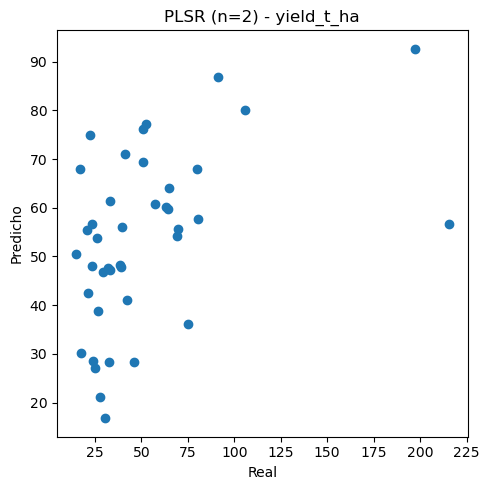

In [4]:
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("pls", PLSRegression(n_components=best_n))
])

final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test).ravel()

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"✅ TEST RMSE: {rmse_test:.4f} ({TARGET})")
print(f"✅ TEST R2:   {r2_test:.4f}")

# scatter real vs pred
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_test)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title(f"PLSR (n={best_n}) - {TARGET}")
plt.tight_layout()
plt.show()


In [5]:
OUT12 = RESULTADO_DIR / "PASO_12_PLSR"
OUT12.mkdir(parents=True, exist_ok=True)

# guardar predicciones test
pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_test
})
pred_path = OUT12 / f"plsr_test_predictions_{TARGET}.csv"
pred_df.to_csv(pred_path, index=False)

# coeficientes (aprox. importancia)
coef = final_model.named_steps["pls"].coef_.ravel()
coef_df = pd.DataFrame({"feature": X.columns, "coef": coef}).sort_values("coef", ascending=False)
coef_path = OUT12 / f"plsr_coefficients_{TARGET}.csv"
coef_df.to_csv(coef_path, index=False)

print("✅ Guardado:", pred_path)
print("✅ Guardado:", coef_path)
display(coef_df.head(15))


✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_12_PLSR\plsr_test_predictions_yield_t_ha.csv
✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_12_PLSR\plsr_coefficients_yield_t_ha.csv


,feature,coef
2,CHLGR_mean_20251210,3.847006
17,SR_mean_20251210,3.522692
7,NDVI_mean_20251103,3.085373
16,SR_mean_20251103,2.791433
12,SAVI2_mean_20251002,2.681350
8,NDVI_mean_20251210,2.079643
5,MARI_mean_20251210,0.370403
19,VF_20251103,-0.284955
4,MARI_mean_20251103,-0.867289
9,OSAVI_mean_20251002,-1.038575
